In [1]:
from pathlib import Path
import colokroll as cr
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

/users/PAS2598/duarte63/GitHub/colok-roll/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Uplaod your image
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_30_min_3.ome.tiff")

loader = cr.ImageLoader(auto_convert=False)
image = loader.load_image(image_path)
channel_names = loader.get_channel_names()

INFO: Found 1 Channel elements but SizeC is 4. Adding default names.
INFO: Extracted metadata from OME-XML: pixel_size=0.108333333333333μm, channels=4
INFO: Squeezed singleton dim(s): (37, 1800, 1800, 4, 1) -> (37, 1800, 1800, 4)
INFO: Successfully loaded TIFF image with shape: (37, 1800, 1800, 4)


Loaded image shape: (37, 1800, 1800, 4)
Channels: ['Channel_0', 'Channel_1', 'Channel_2', 'Channel_3']
Pixel size: 0.108333333333333 um


In [3]:
# Z slice selection

result = cr.select_z_slices(
    image,
    method="combined",
    strategy="relative",
    threshold=0.6,
    smooth=3,
)

#Apply the filtering to the image
filtered_image = image[result.indices_keep]
print(f"Kept {len(result.indices_keep)} slices out of {image.shape[0]}")

Kept 23 slices out of 37


In [4]:
#Rename the channels

new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
loader.rename_channels(new_channel_names)
channel_names = loader.get_channel_names()

INFO: Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


Channels: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [6]:
import time
import cupy as cp

bg_subtractor = cr.BackgroundSubtractor()

results = {}

for i, ch in enumerate(channel_names):
    ch_data = filtered_image[:, :, :, i]
    t0 = time.perf_counter()
    corrected, meta = bg_subtractor.subtract_background(
        image=ch_data,
        channel_name=ch,
        # method omitted -> auto search + full run
    )
    cp.cuda.Stream.null.synchronize()
    dt = time.perf_counter() - t0

    results[ch] = (corrected, meta)

INFO: Initializing CUDA-accelerated background subtractor
INFO: GPU Memory: 39.1GB free / 39.5GB total
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=55)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=60)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=65)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=70)
INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=12
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=14
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=16
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=14
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=100)
INFO: Proce

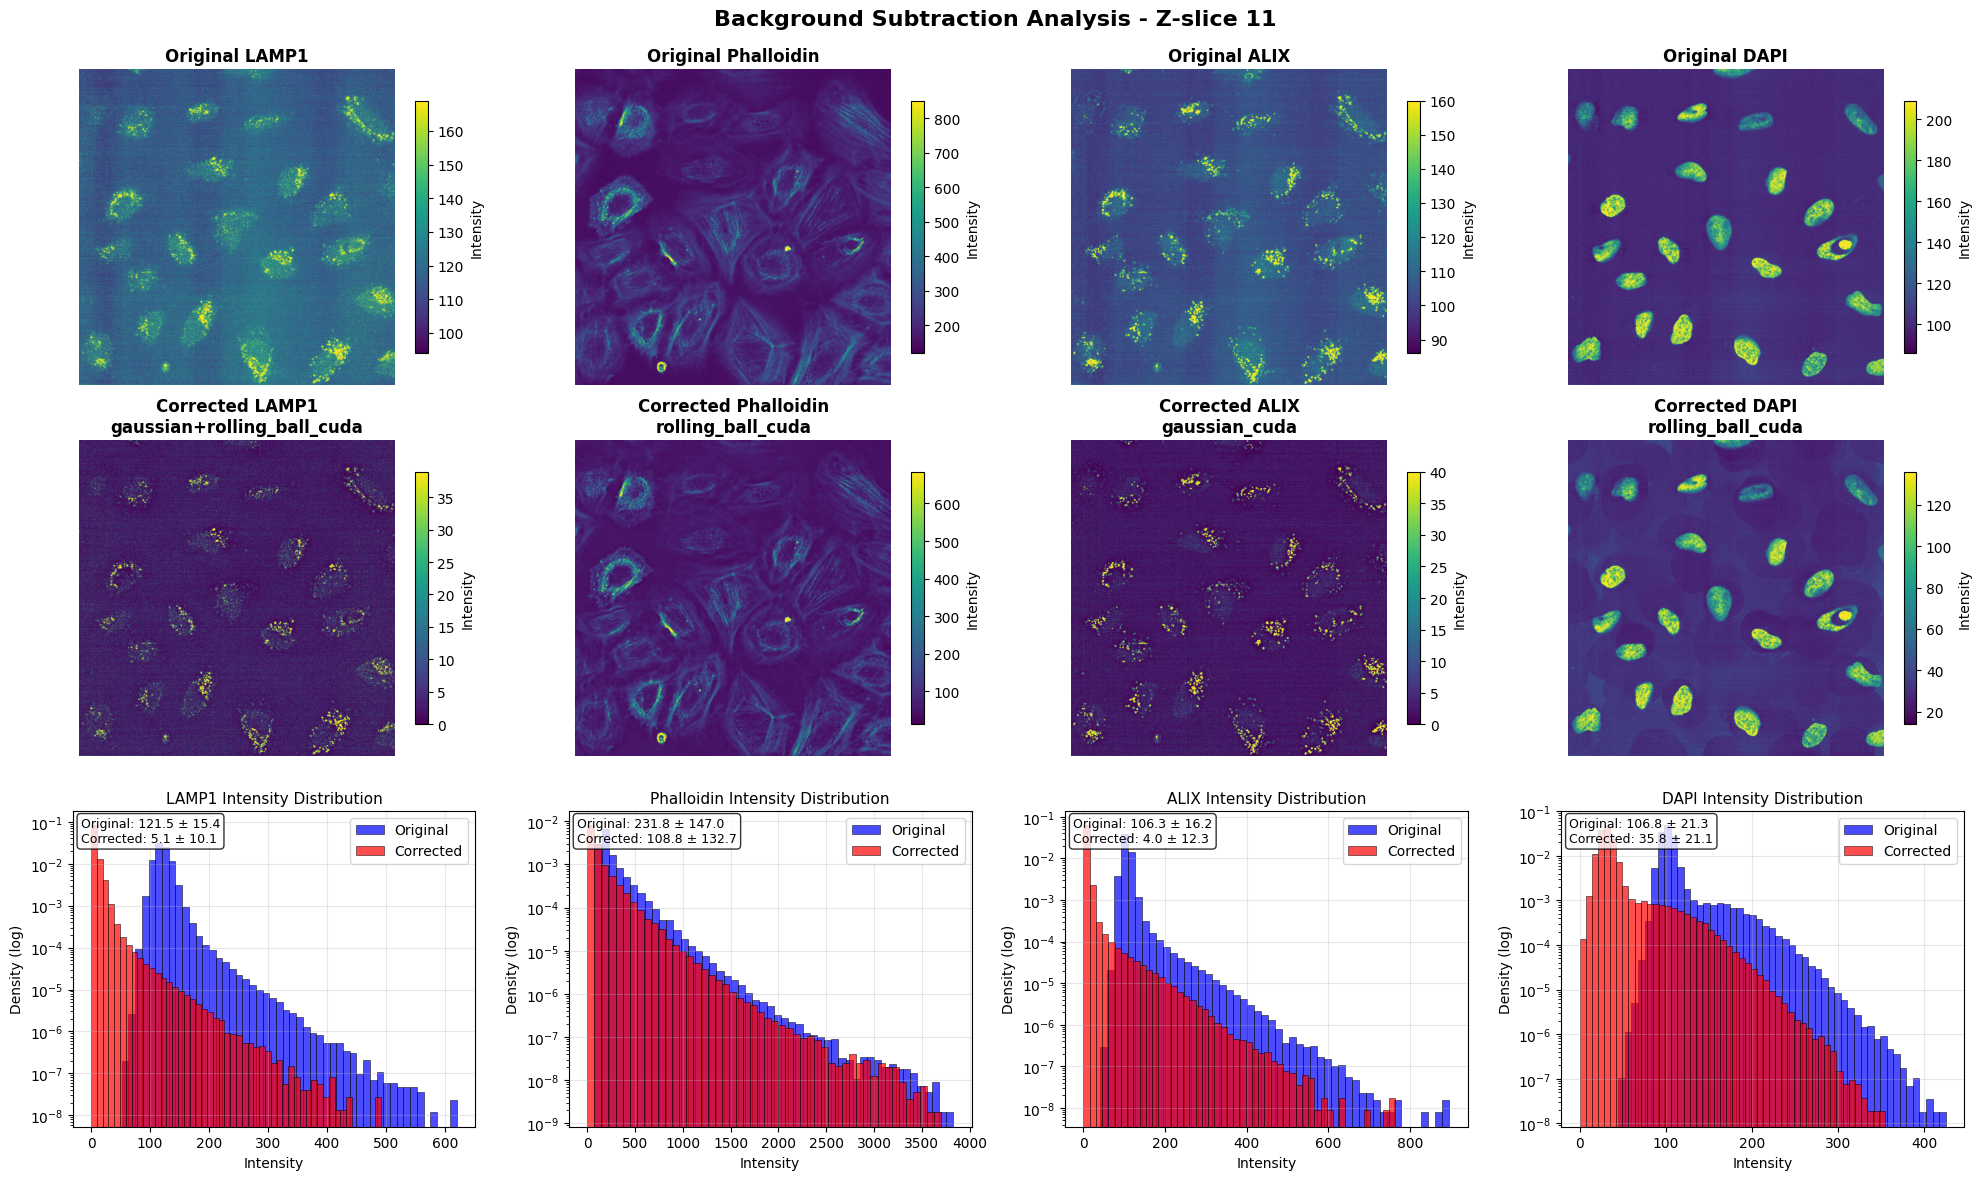

In [7]:
#visualize the effect of background removal.

middle_slice_idx = filtered_image.shape[0]//2


fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=filtered_image,
    corrected_results=results,
    channel_names=channel_names,
    z_slice=middle_slice_idx,
    figsize=(5*len(channel_names), 12)
)

In [9]:
# Use the corrected 3D arrays (Z, Y, X) from your results dict
prep = {k: v[0] if isinstance(v, (tuple, list)) else v for k, v in results.items()}

segmenter = cr.CellSegmenter(
    output_dir=Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"),
    auto_resize=False,          # use fixed candidates instead of auto
    resize_candidates=[600, 400],
    # optional: tighten flow/cellprob if needed
    # flow_threshold=0.4,
    # cellprob_threshold=0.0,
)

seg = segmenter.segment_from_results(
    results=prep,
    channel_a="Phalloidin",     # cell boundary channel
    channel_b="DAPI",           # nuclei
    channel_weights=(1.0, 0.10),# strongly favor Phalloidin to avoid nuclei dominance
    projection="mip",
    output_format="png8",
    save_basename=image_path.stem,
)

print("Mask:", seg.mask_path)
print("Outlines:", seg.outlines_path)
print("Mask shape:", seg.mask_array.shape)

INFO: Creating max projection from shape (23, 1800, 1800, 2)
INFO: Created max projection with shape (1800, 1800, 2)
INFO: HTTP Request: GET https://huggingface.co/api/spaces/mouseland/cellpose "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://huggingface.co/api/spaces/mouseland/cellpose/runtime "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/config "HTTP/1.1 200 OK"


Loaded as API: https://mouseland-cellpose.hf.space ✔


INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/info?serialize=False "HTTP/1.1 200 OK"
INFO: Calling /update_button with image /tmp/cellpose_composite.png
INFO: HTTP Request: HEAD https://huggingface.co/api/telemetry/py_client/initiated "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/heartbeat/32d0b1e8-efd7-46f5-b297-3b0dd18284f1 "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/upload "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://mouseland-cellpose.hf.space/gradio_api/queue/join "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/queue/data?session_hash=32d0b1e8-efd7-46f5-b297-3b0dd18284f1 "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-cellpose.hf.space/gradio_api/file=/tmp/gradio/5a95b78fec9a0abf3cb645b4ac7b28be597194f7b11c06730056f0b94616c92a/cellpose_composite.png "HTTP/1.1 200 OK"
INFO: HTTP Request: GET https://mouseland-ce

Mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_30_min_3.ome_masks.tif
Outlines: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_30_min_3.ome_outlines.png
Mask shape: (1800, 1800)


In [17]:
#from colokroll.analysis.colocalization import compute_colocalization

mask_path = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_30_min_3.ome_masks.tif")

res = cr.compute_colocalization(
    image=results,
    mask=mask_path,
    channel_a="ALIX",
    channel_b="LAMP1",
    channel_names=channel_names,
    pearson_winsor_clip=0.1,
    thresholding="costes",        # or "costes"/"percentile"/"fixed"/"none"
    min_area="auto",
    min_area_fraction=0.70,
    max_border_fraction=0.10,
    border_margin_px=1,
    drop_label_1=True,
    plot_mask=True,            # set True if you want the kept/removed label plot
)

# Per-cell metrics (one row per kept label)
df_cells = pd.DataFrame(res["results"]["per_label"]).sort_values("label")
# Total-image metrics (single row)
df_total = pd.DataFrame([res["results"]["total_image"]])

# Quick access to key metrics
pearson_total = res["results"]["total_image"]["pearson_r"]
manders_m1_total = res["results"]["total_image"]["manders_m1"]
manders_m2_total = res["results"]["total_image"]["manders_m2"]
jaccard_total = res["results"]["total_image"]["jaccard"]

pearson_total, manders_m1_total, manders_m2_total, jaccard_total

INFO: Loading TIF mask: /fs/scratch/PAS2598/duarte63/outputs/cellpose/anti_ALIX_30_min_3.ome_masks.tif
INFO: Mask contains 28 unique values
INFO: Successfully loaded mask with shape: (1800, 1800)
INFO: Loaded labeled mask with integer dtype: uint16
INFO: Loaded labeled mask with integer dtype: int32
INFO: Estimated min_area threshold: fraction=0.7, median_area=88047 -> thr=61632
INFO: Auto-estimated min_area threshold: 61632 (fraction=0.7)
INFO: Starting compute_colocalization(ch_a=ALIX, ch_b=LAMP1, normalization_scope=none, min_area=61632, max_border_fraction=0.1, border_margin_px=1, plot_mask=True)
INFO: Image loaded: shape=(23, 1800, 1800, 4), channels=['LAMP1', 'Phalloidin', 'ALIX', 'DAPI'] | Mask loaded: shape=(1800, 1800), unique_labels=27
INFO: Manders coefficients (M1/M2) weighting: voxel (thresholding=costes, z-slices=23)
INFO: Filtering labels: min_area=61632, max_border_fraction=0.1, border_margin_px=1 -> kept=22, removed=4
INFO: Prepared mask plot (kept=22, removed=5, show=

(0.35596283726844996,
 0.5055192947727383,
 0.5038739449508228,
 0.3236762303252528)